In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Load the data
data = pd.read_csv('/Users/xinyue/Desktop/Project 2/Inner Melbourne.csv')
# Identify columns with dates and create new names
date_columns = [col for col in data.columns if "Unnamed" not in col]
new_columns = ['Region', 'Suburb']  # assuming the first two unnamed columns are region and suburb identifiers

# Loop through date columns and append Count and Median with respective date
for i, date in enumerate(date_columns):
    count_index = 2 * i + 83  # Adjust based on your specific pattern
    median_index = 2 * i + 85  # Adjust based on your specific pattern
    new_columns.append(f'Count {date}')
    new_columns.append(f'Median {date}')

# Set new column names to the DataFrame
data.columns = new_columns


# Display the first few rows to check the new column names
print(data.head())


            Region                                 Suburb Count Mar 2010  \
0  Inner Melbourne  Albert Park-Middle Park-West St Kilda            956   
1              NaN                               Armadale            589   
2              NaN                          Carlton North            487   
3              NaN                      Carlton-Parkville          3,369   
4              NaN                        CBD-St Kilda Rd          5,612   

  Median Mar 2010 Count Jun 2010 Median Jun 2010 Count Sep 2010  \
0         $425.00            954         $425.00            978   
1         $360.00            600         $360.00            620   
2         $420.00            483         $440.00            505   
3         $340.00          3,350         $340.00          3,221   
4         $410.00          5,628         $410.00          5,703   

  Median Sep 2010 Count Dec 2010 Median Dec 2010  ... Count Mar 2019  \
0         $430.00            961         $445.00  ...            905

In [13]:
# Filtering and renaming columns that contain 'Median'
median_columns = [col for col in data.columns if 'Median' in col]

date_parts = [col.split(' ')[1:] for col in median_columns]  # This splits "Median Mar 2010" into ["Mar", "2010"]
dates = [' '.join(date) for date in date_parts]  # This joins them back to "Mar 2010"

# Rename columns to only have the date as the column name
data.rename(columns=dict(zip(median_columns, dates)), inplace=True)

# Include suburb and region columns
useful_columns = ['Region', 'Suburb'] + dates
data = data[useful_columns]
print(data)

             Region                                 Suburb Mar 2010 Jun 2010  \
0   Inner Melbourne  Albert Park-Middle Park-West St Kilda  $425.00  $425.00   
1               NaN                               Armadale  $360.00  $360.00   
2               NaN                          Carlton North  $420.00  $440.00   
3               NaN                      Carlton-Parkville  $340.00  $340.00   
4               NaN                        CBD-St Kilda Rd  $410.00  $410.00   
5               NaN                 Collingwood-Abbotsford  $400.00  $410.00   
6               NaN                              Docklands  $500.00  $500.00   
7               NaN                         East Melbourne  $405.00  $410.00   
8               NaN                          East St Kilda  $330.00  $335.00   
9               NaN                                 Elwood  $350.00  $360.00   
10              NaN                                Fitzroy  $450.00  $450.00   
11              NaN             Fitzroy 

In [14]:
# Reshape the data
melted_data = data.melt(id_vars='Suburb', var_name='Date', value_name='Median Price')

# Convert 'Date' to datetime
melted_data['Date'] = pd.to_datetime(melted_data['Date'], format='%b %Y', errors='coerce')

# Sort data
melted_data.sort_values(by=['Suburb', 'Date'], inplace=True)
print(melted_data)

                                    Suburb       Date Median Price
23   Albert Park-Middle Park-West St Kilda 2010-03-01      $425.00
46   Albert Park-Middle Park-West St Kilda 2010-06-01      $425.00
69   Albert Park-Middle Park-West St Kilda 2010-09-01      $430.00
92   Albert Park-Middle Park-West St Kilda 2010-12-01      $445.00
115  Albert Park-Middle Park-West St Kilda 2011-03-01      $440.00
..                                     ...        ...          ...
895                                 Toorak 2019-06-01      $500.00
918                                 Toorak 2019-09-01      $500.00
941                                 Toorak 2019-12-01      $500.00
964                                 Toorak 2023-03-01      $550.00
21                                  Toorak        NaT          NaN

[966 rows x 3 columns]


In [15]:
# Convert all median price columns to floats and handle potential formatting issues
for col in data.columns[2:]:  # Assuming the first two columns are 'Region' and 'Suburb'
    data[col] = pd.to_numeric(data[col].str.replace('$', '').replace(',', ''), errors='coerce')

# Reshape the data
melted_data = data.melt(id_vars=['Suburb'], var_name='Date', value_name='Median Price')

# Convert 'Date' to datetime
melted_data['Date'] = pd.to_datetime(melted_data['Date'], format='%b %Y', errors='coerce')

# Remove any rows with missing data, particularly in 'Date' or 'Median Price'
melted_data.dropna(subset=['Date', 'Median Price'], inplace=True)

# Ensure 'Median Price' is a float
melted_data['Median Price'] = melted_data['Median Price'].astype(float)
print(melted_data)

                                    Suburb       Date  Median Price
23   Albert Park-Middle Park-West St Kilda 2010-03-01         425.0
24                                Armadale 2010-03-01         360.0
25                           Carlton North 2010-03-01         420.0
26                       Carlton-Parkville 2010-03-01         340.0
27                         CBD-St Kilda Rd 2010-03-01         410.0
..                                     ...        ...           ...
961                            South Yarra 2023-03-01         480.0
962                              Southbank 2023-03-01         553.0
963                               St Kilda 2023-03-01         420.0
964                                 Toorak 2023-03-01         550.0
965                            Group Total 2023-03-01         495.0

[943 rows x 3 columns]


# Generate future 3 years growth rates using ARIMA model 

Processing Albert Park-Middle Park-West St Kilda


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

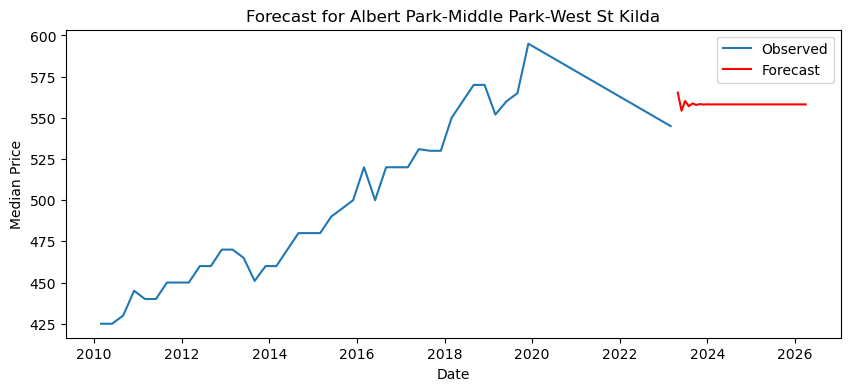

Processing Armadale


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

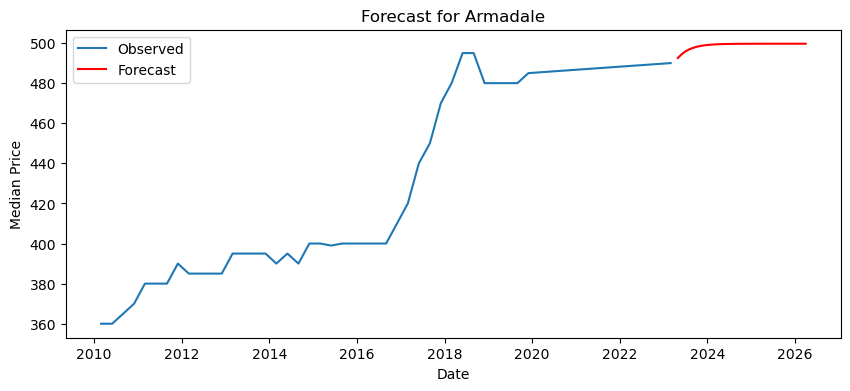

Processing CBD-St Kilda Rd


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

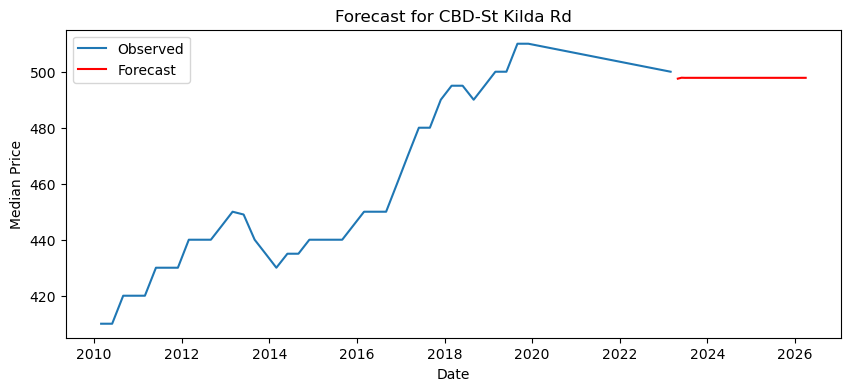

Processing Carlton North


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

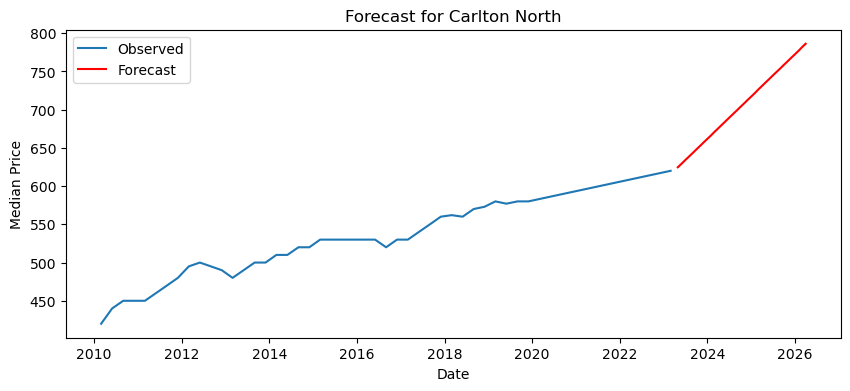

Processing Carlton-Parkville


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

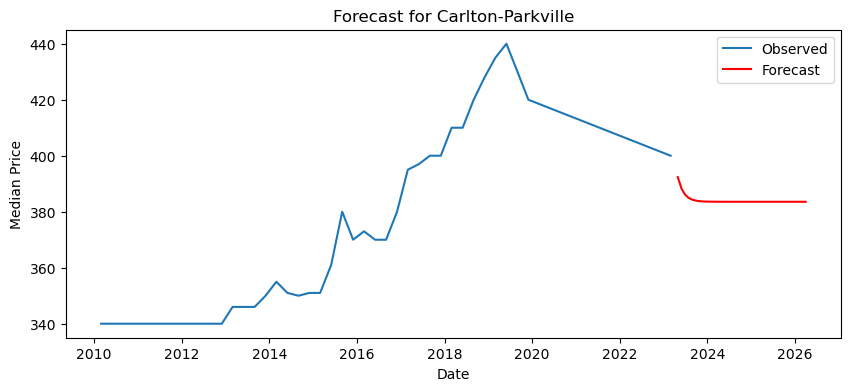

Processing Collingwood-Abbotsford


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

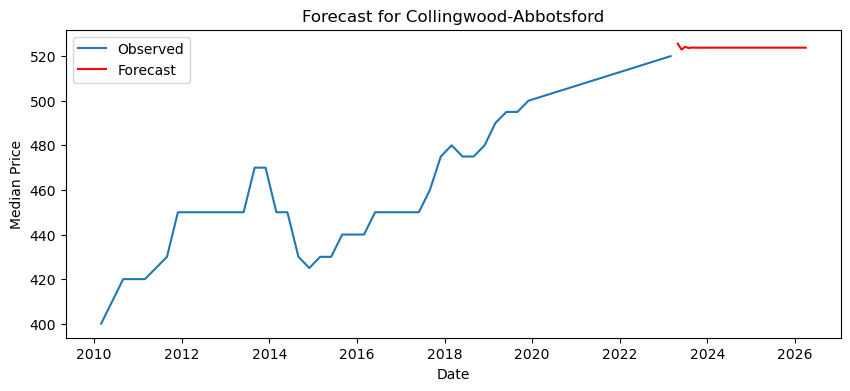

Processing Docklands


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

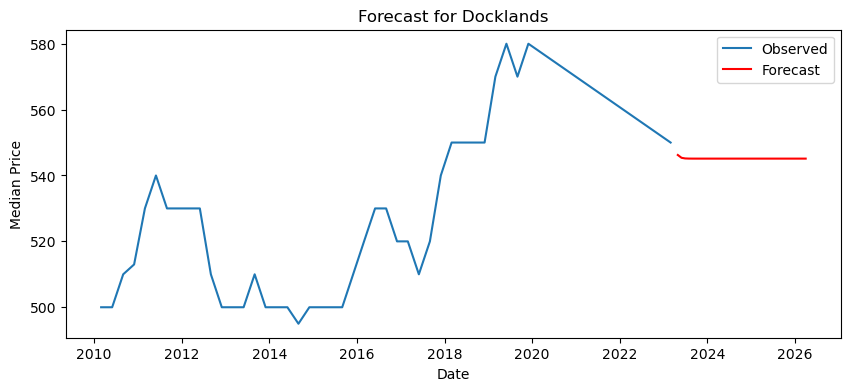

Processing East Melbourne


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/U

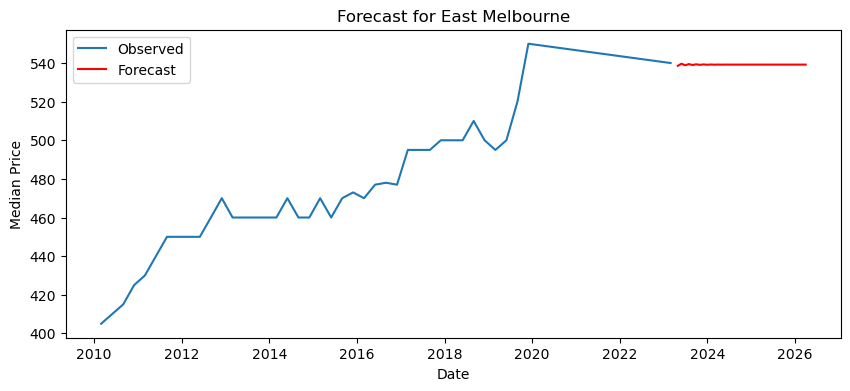

Processing East St Kilda


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

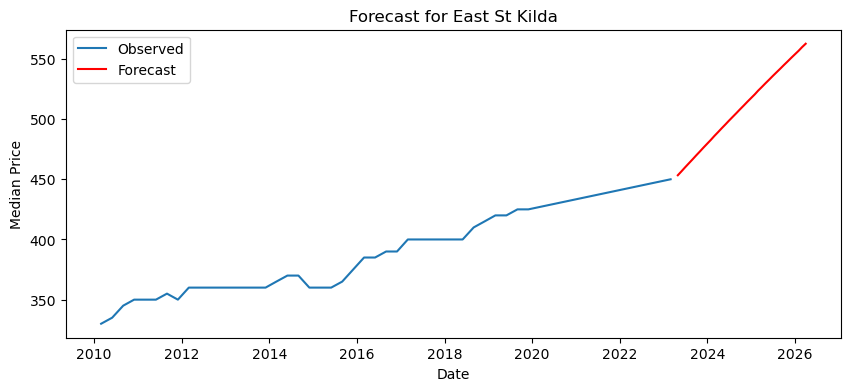

Processing Elwood


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

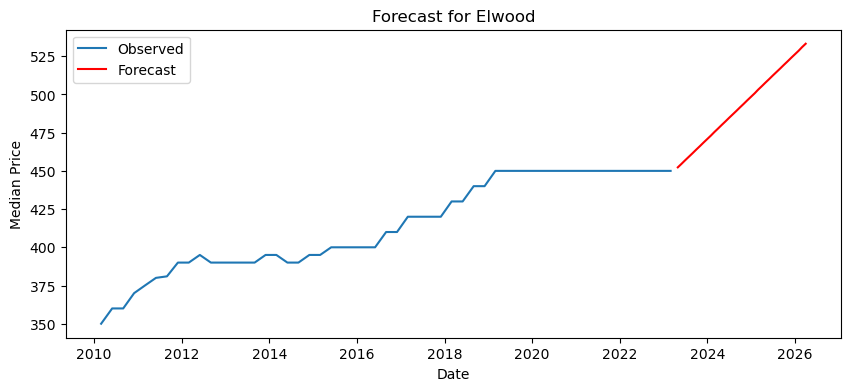

Processing Fitzroy


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

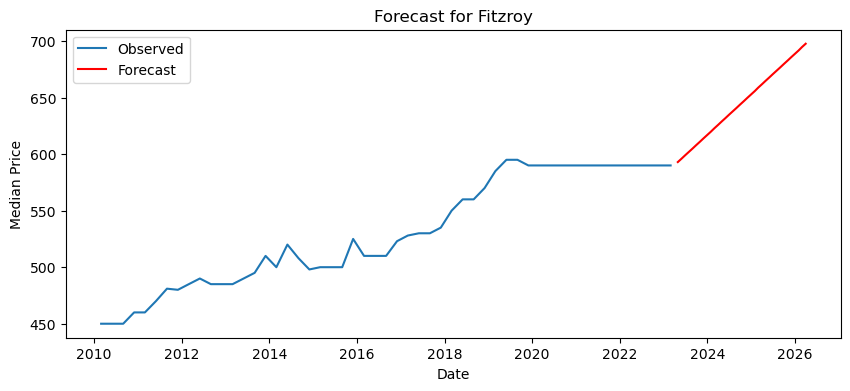

Processing Fitzroy North-Clifton Hill


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/U

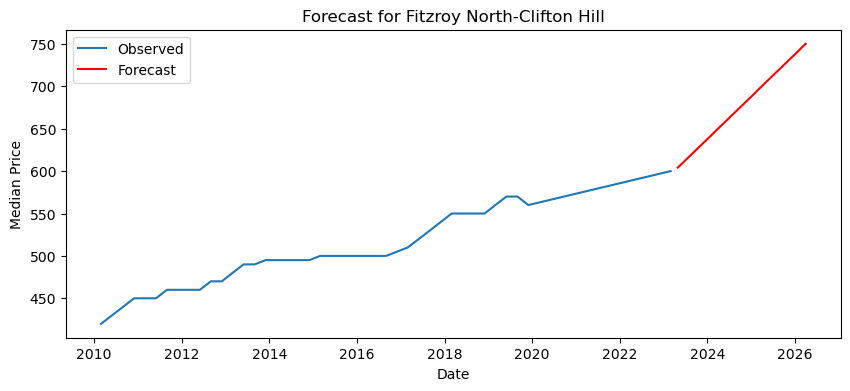

Processing Flemington-Kensington


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/xinyue/opt/anaconda3/

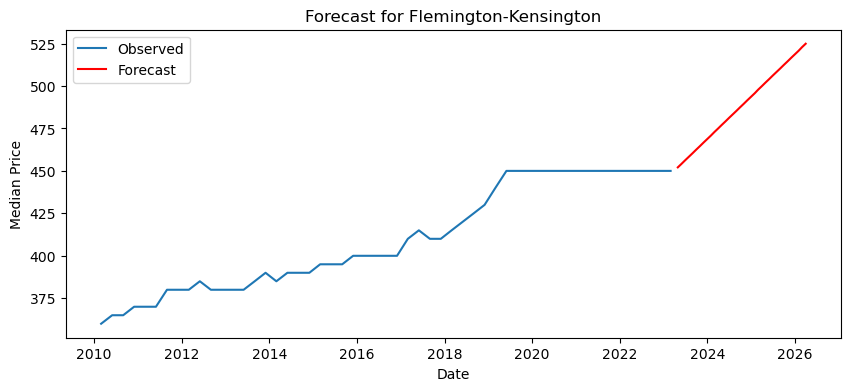

Processing Group Total


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/xinyue/opt/anaconda3/

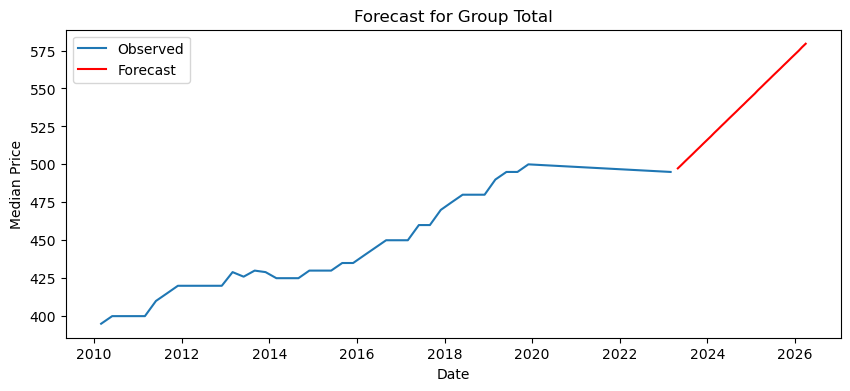

Processing North Melbourne-West Melbourne


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/xinyue/opt/a

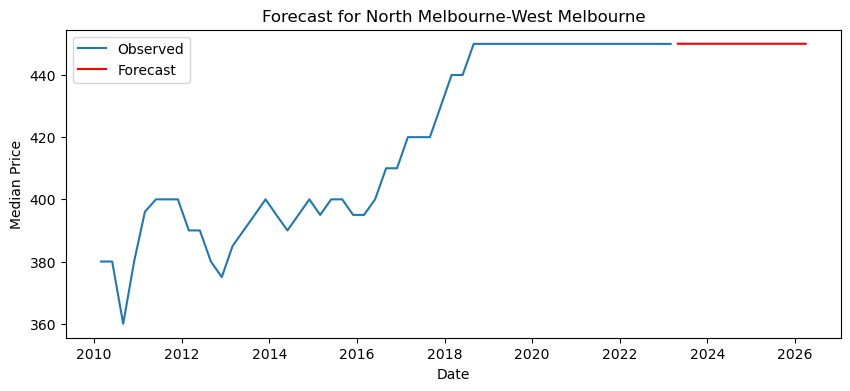

Processing Port Melbourne


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

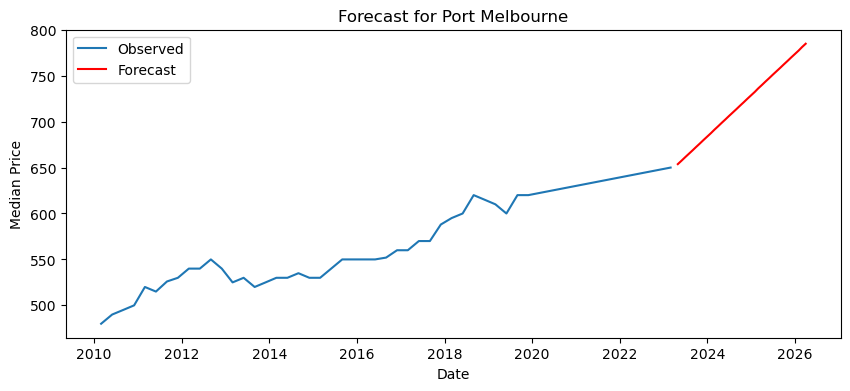

Processing Prahran-Windsor


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

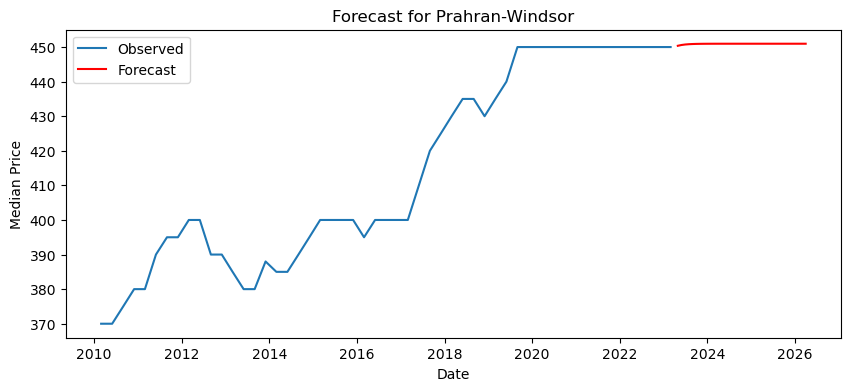

Processing Richmond-Burnley


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

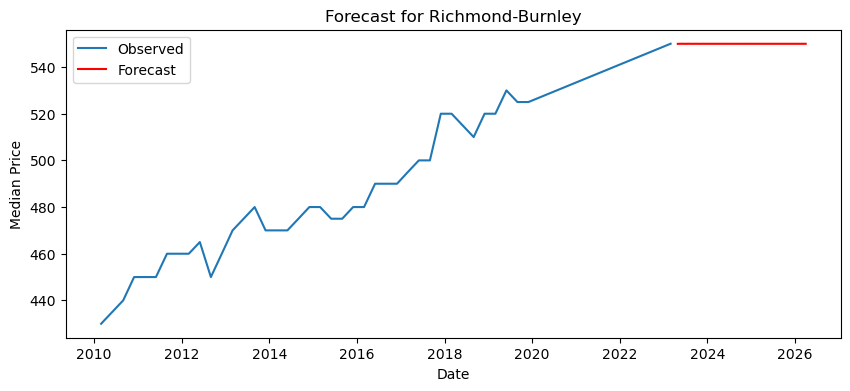

Processing South Melbourne


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

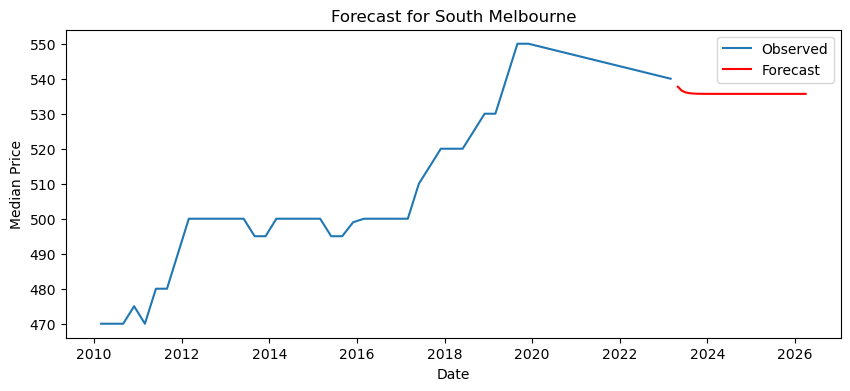

Processing South Yarra


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

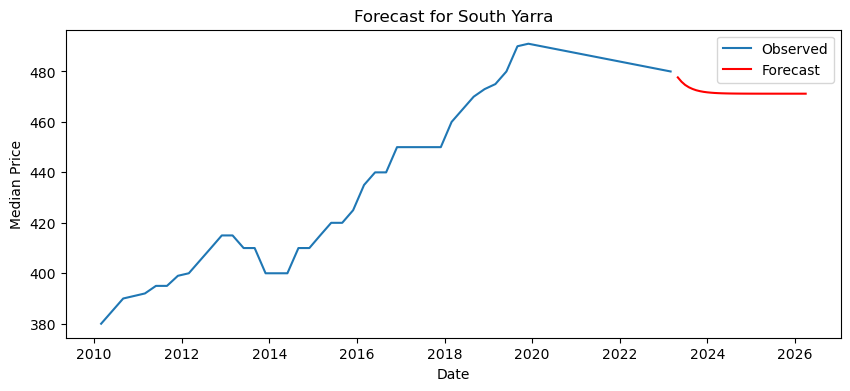

Processing Southbank


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

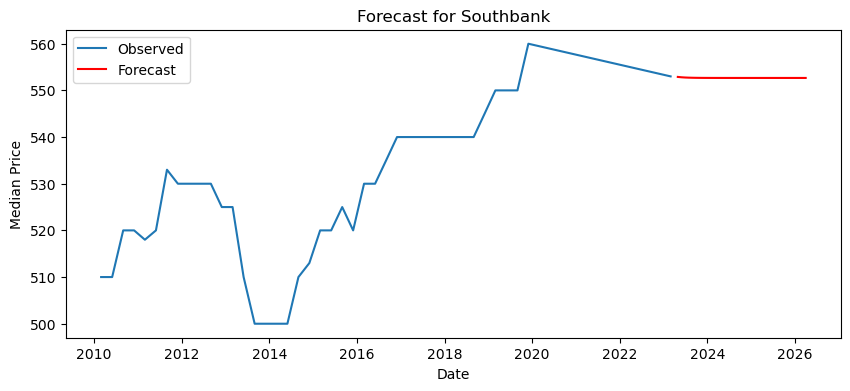

Processing St Kilda


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

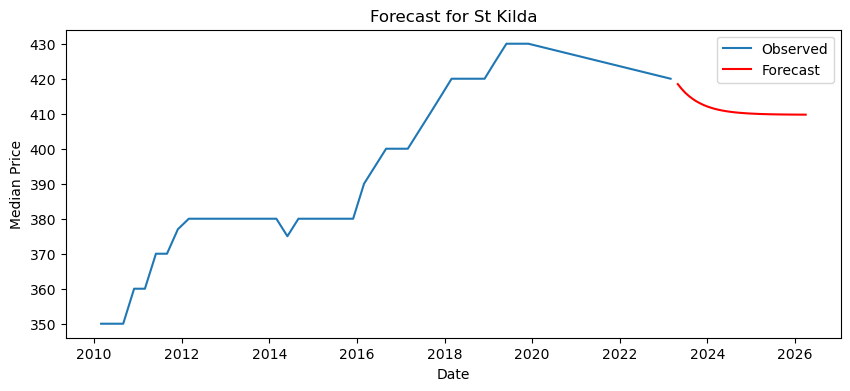

Processing Toorak


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

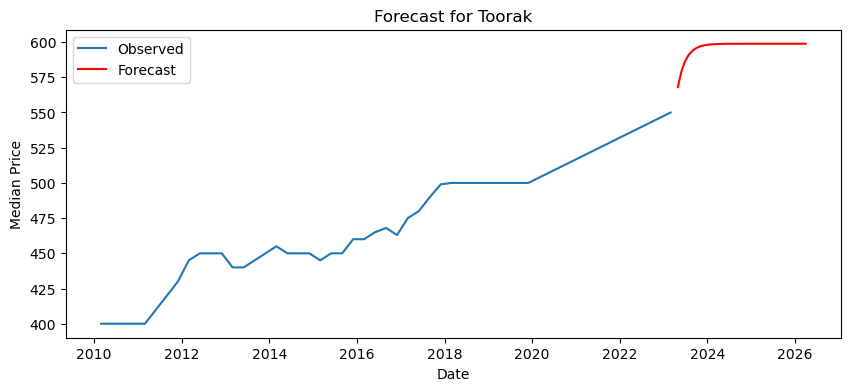

In [16]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'melted_data' is your DataFrame that contains at least the columns 'Date' and 'Median Price'
# and 'Date' is already converted to pandas datetime format
grouped = melted_data.groupby('Suburb')

# Loop through each suburb
for suburb, group in grouped:
    print(f"Processing {suburb}")
    try:
        # Ensure there are enough data points to model
        if len(group) > 20:
            # Ensure the data is sorted by date
            group = group.sort_values(by='Date')
            
            # Fit ARIMA model (consider optimizing the order based on ACF/PACF plots)
            model = ARIMA(group['Median Price'], order=(1,1,1))
            model_fit = model.fit()
            
            # Forecasting for the next 36 months (3 years)
            forecast = model_fit.forecast(steps=36)
            
            # Plotting
            plt.figure(figsize=(10, 4))
            plt.plot(group['Date'], group['Median Price'], label='Observed')
            future_dates = pd.date_range(start=group['Date'].iloc[-1], periods=37, freq='M')[1:]
            plt.plot(future_dates, forecast, label='Forecast', color='red')
            plt.title(f"Forecast for {suburb}")
            plt.xlabel('Date')
            plt.ylabel('Median Price')
            plt.legend()
            plt.show()
            
    except Exception as e:
        print(f"Failed to fit model for {suburb}: {e}")


# Training ARIMA model base on data from 2010 to 2016 and testing the data from 2017 to 2019 and 2023. 

Processing Albert Park-Middle Park-West St Kilda


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

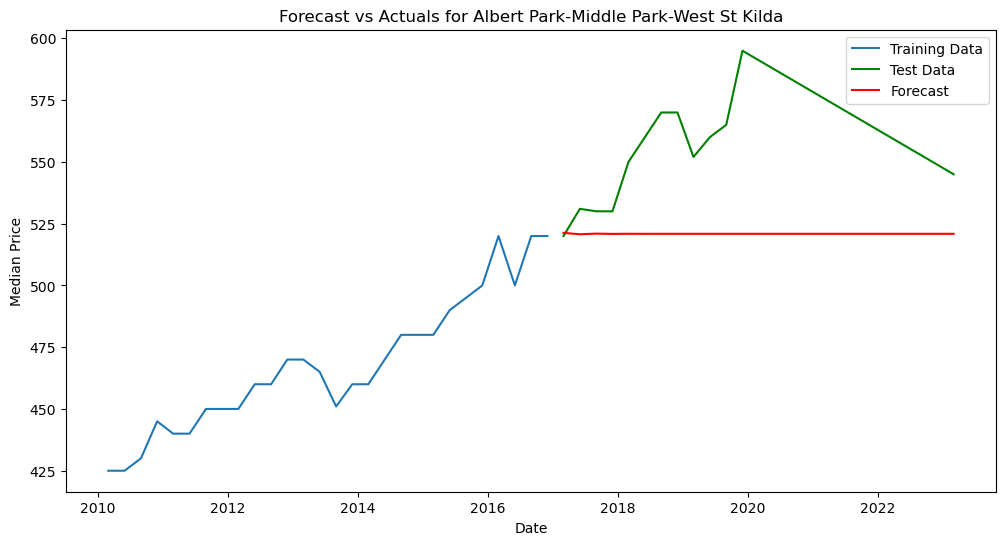

Processing Armadale


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

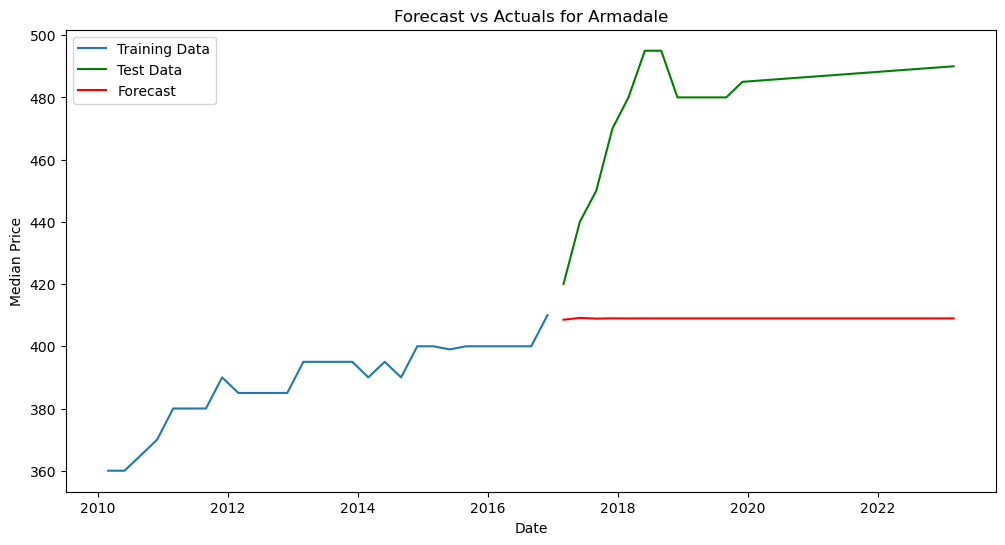

Processing CBD-St Kilda Rd


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

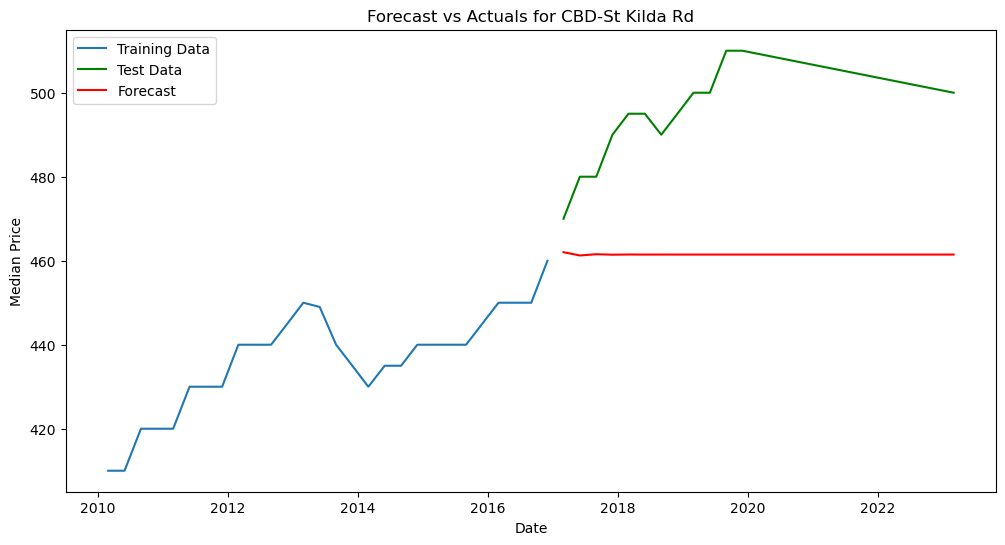

Processing Carlton North


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

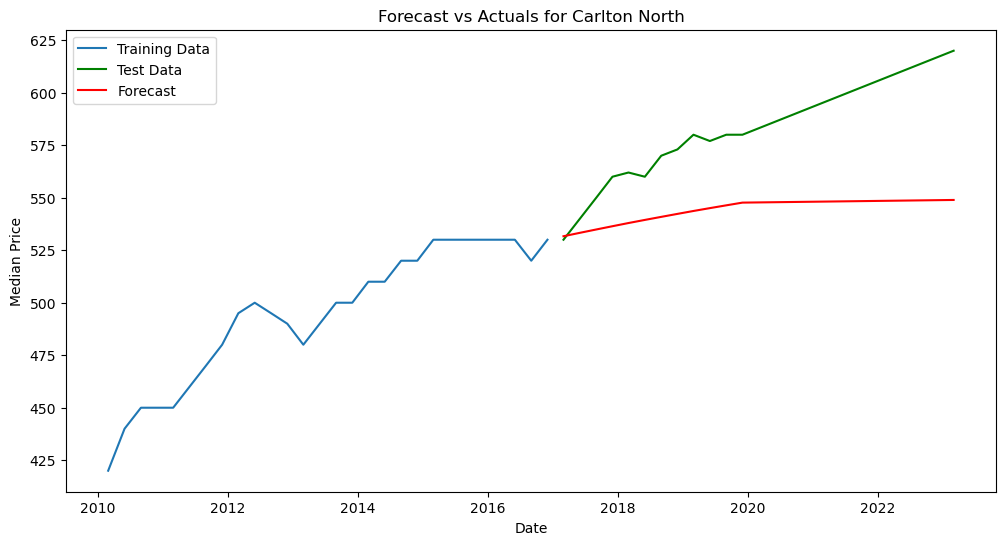

Processing Carlton-Parkville


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

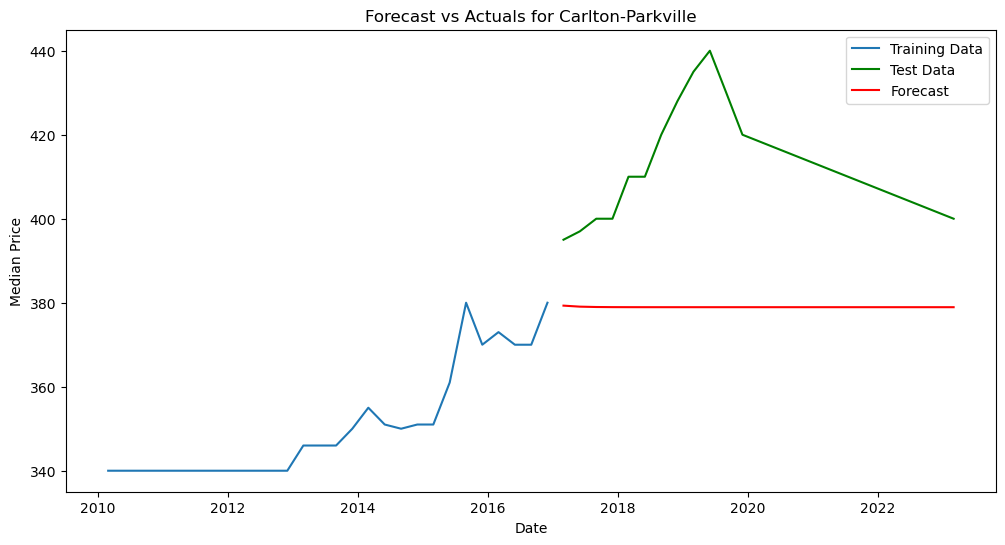

Processing Collingwood-Abbotsford


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

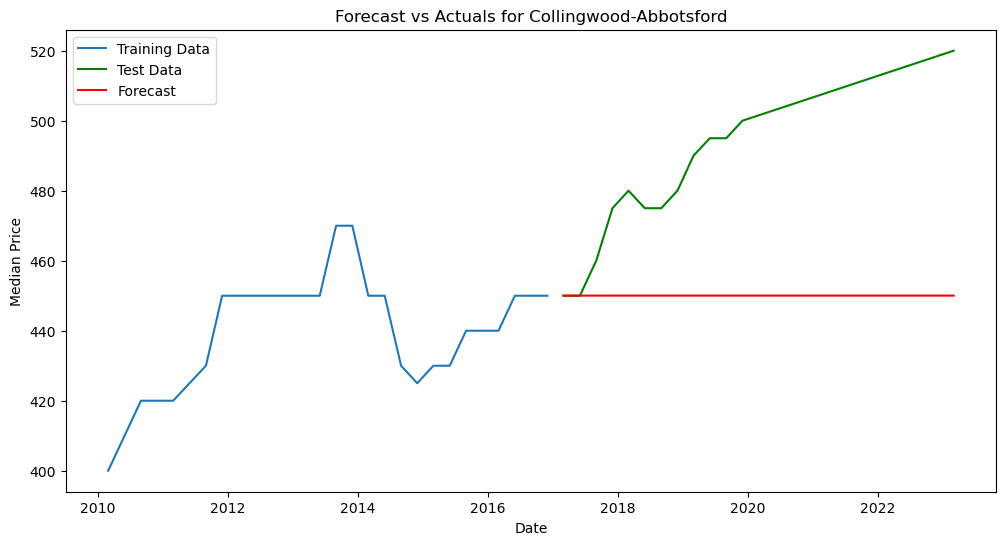

Processing Docklands


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

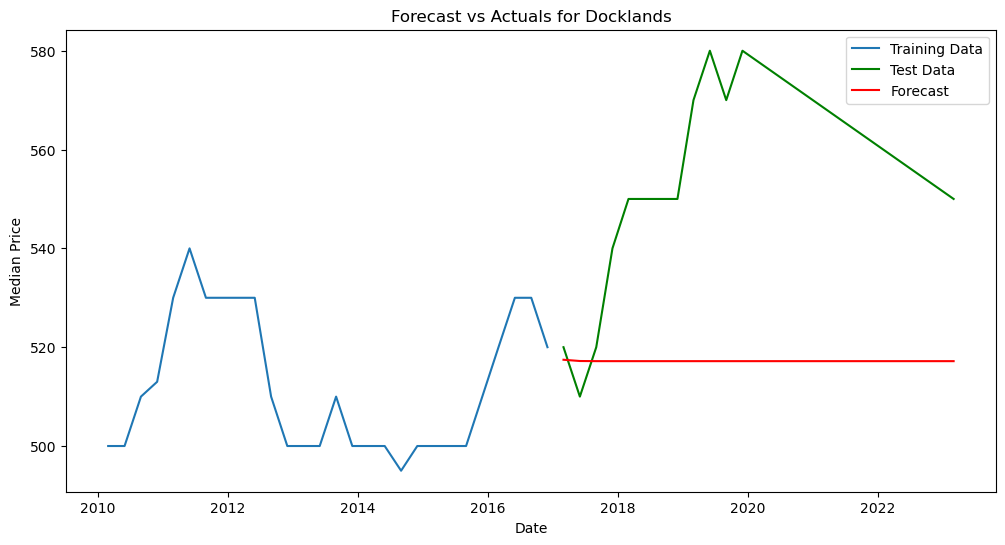

Processing East Melbourne


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/U

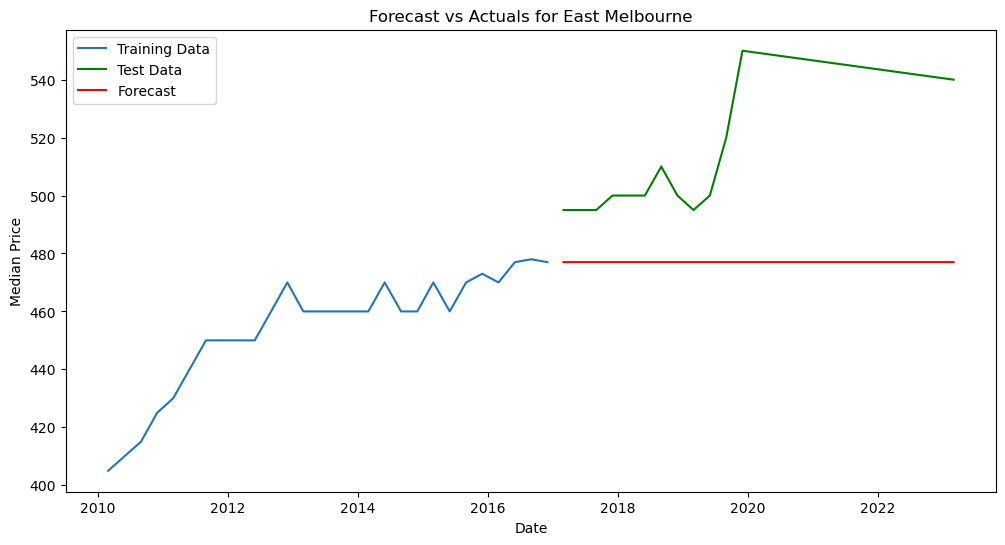

Processing East St Kilda


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

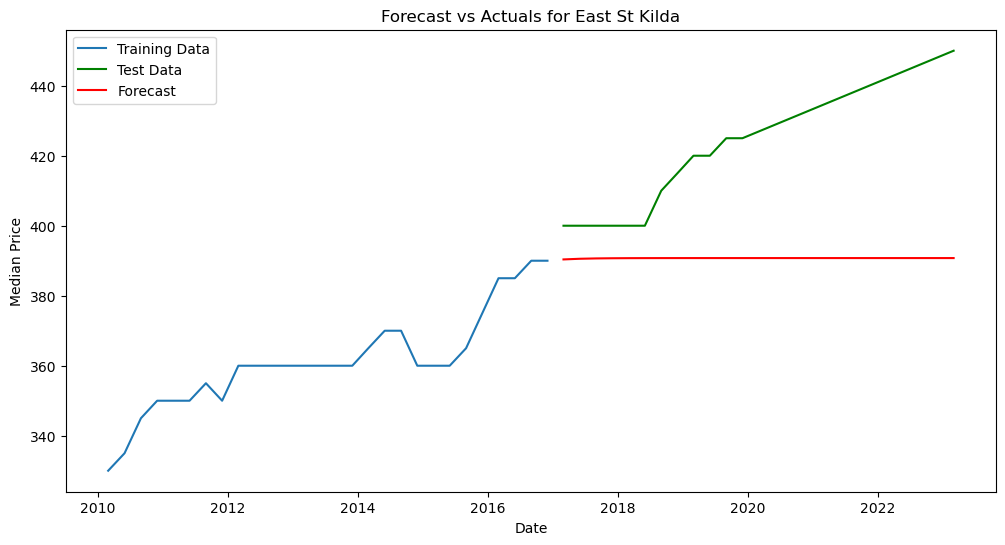

Processing Elwood


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

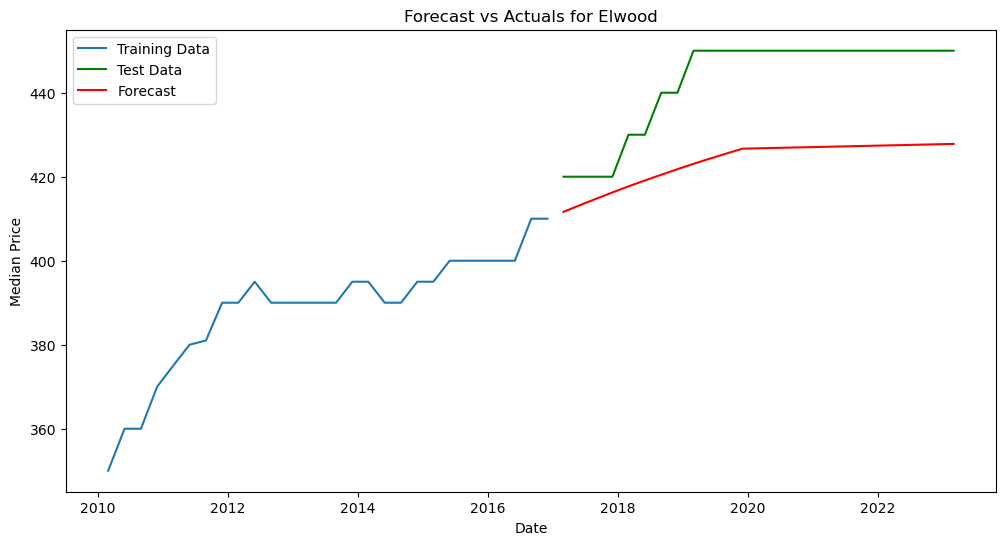

Processing Fitzroy


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

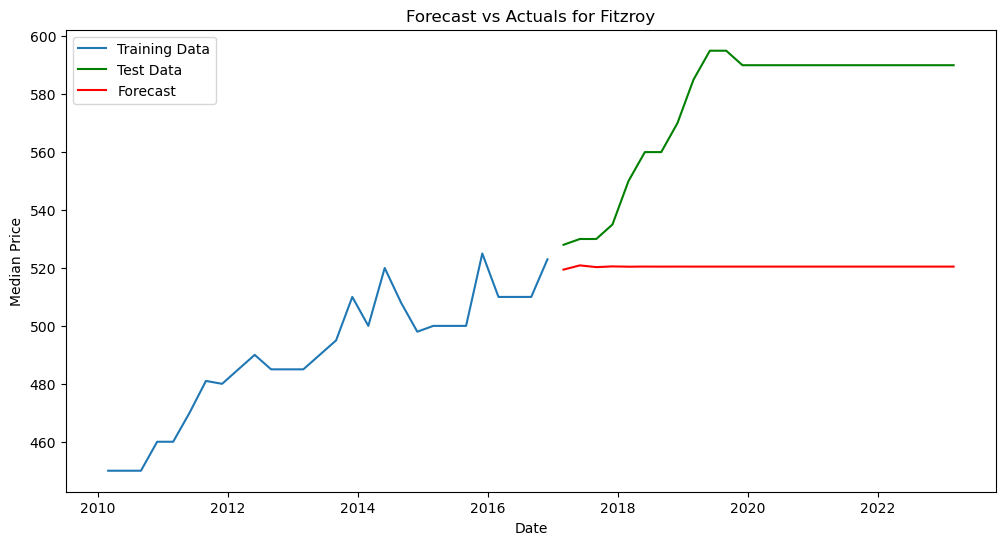

Processing Fitzroy North-Clifton Hill


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

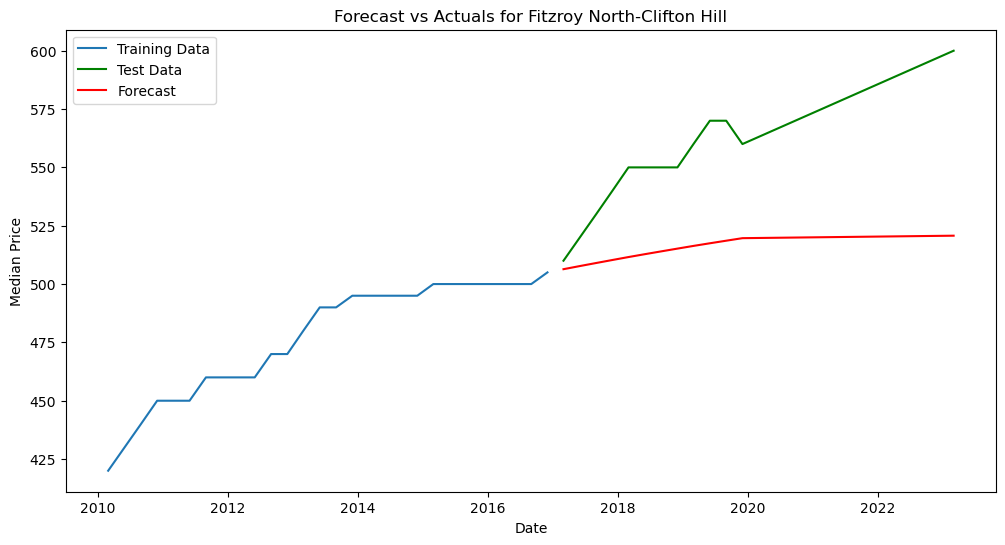

Processing Flemington-Kensington


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/U

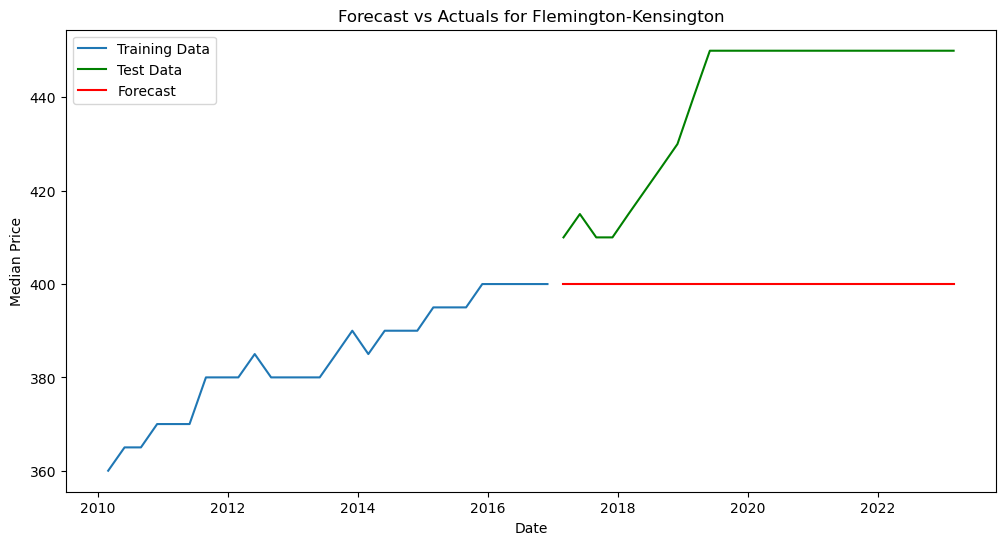

Processing Group Total


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

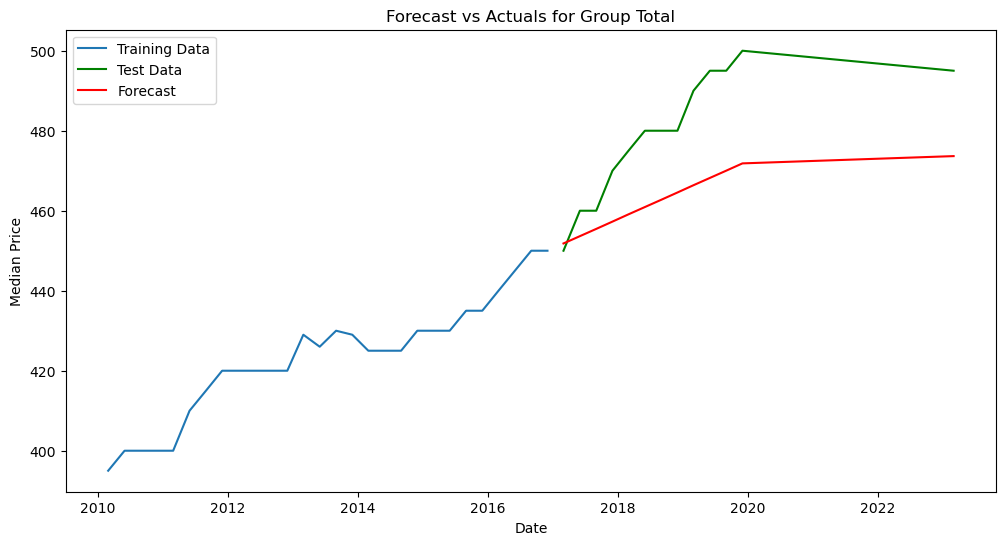

Processing North Melbourne-West Melbourne


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

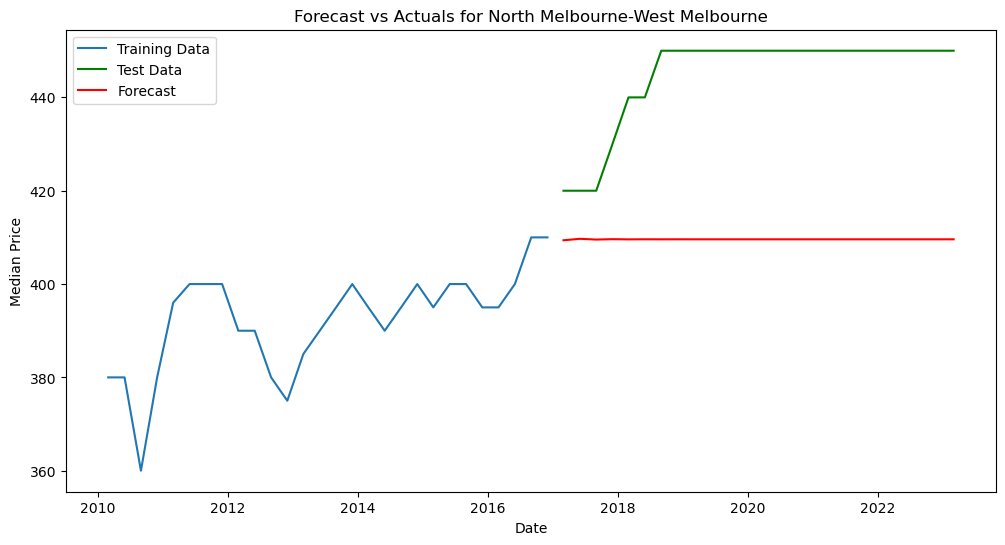

Processing Port Melbourne


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

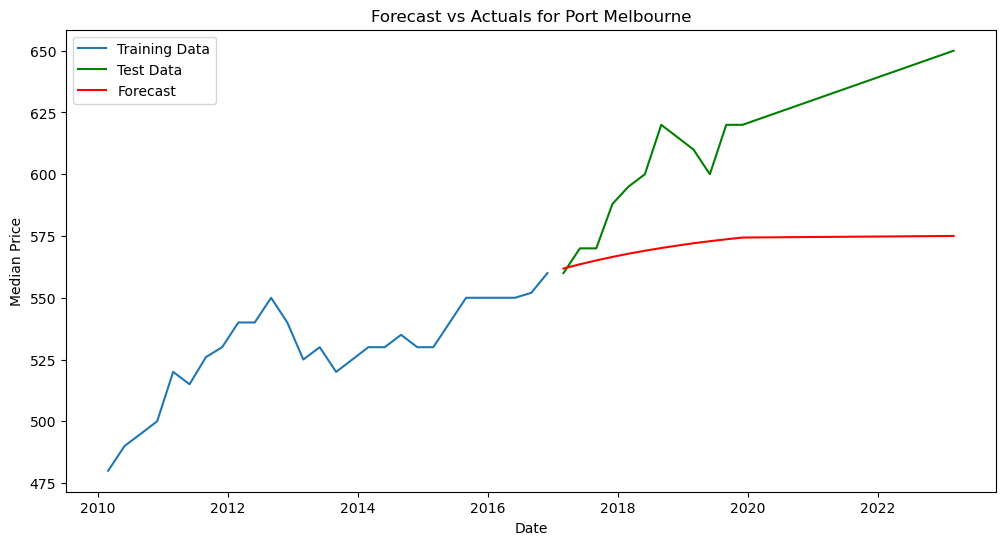

Processing Prahran-Windsor


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

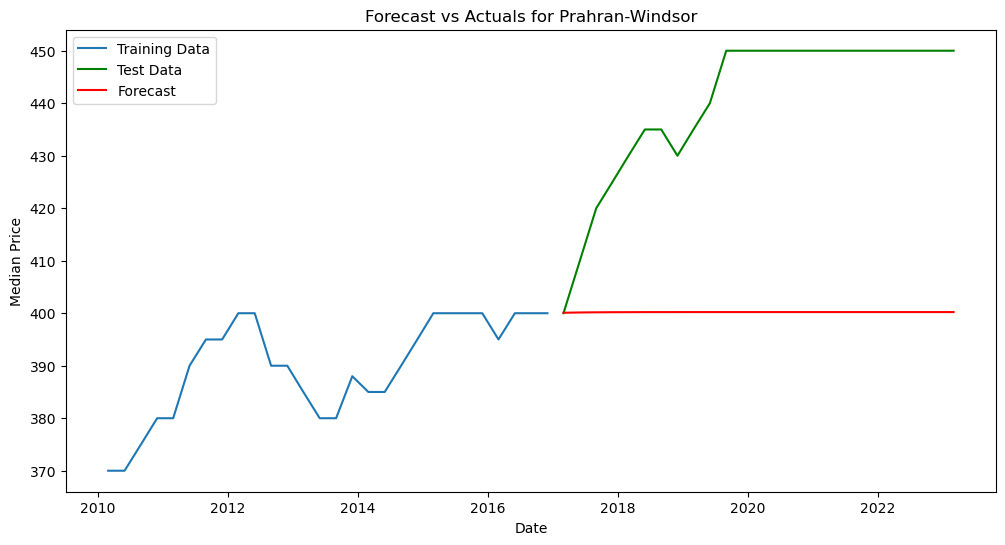

Processing Richmond-Burnley


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/U

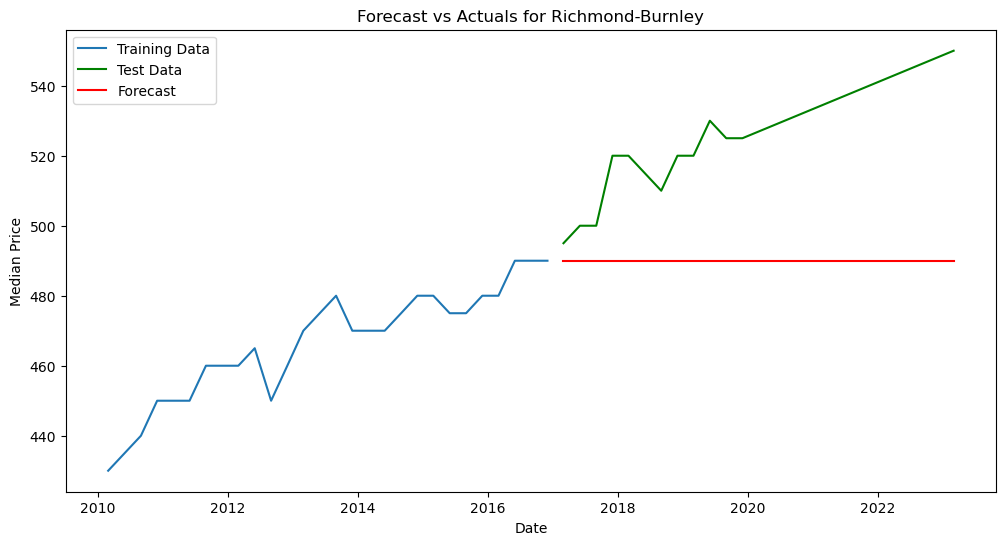

Processing South Melbourne


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

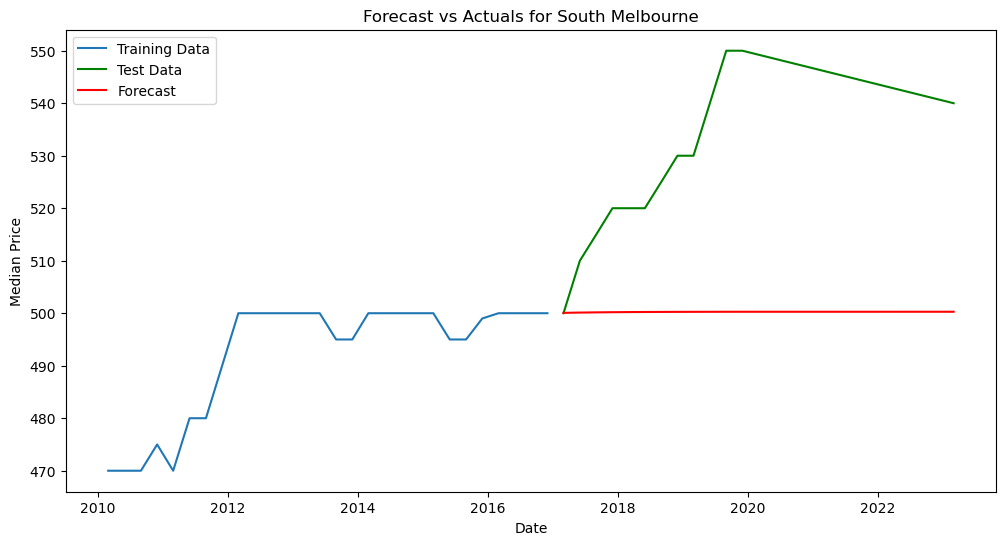

Processing South Yarra


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

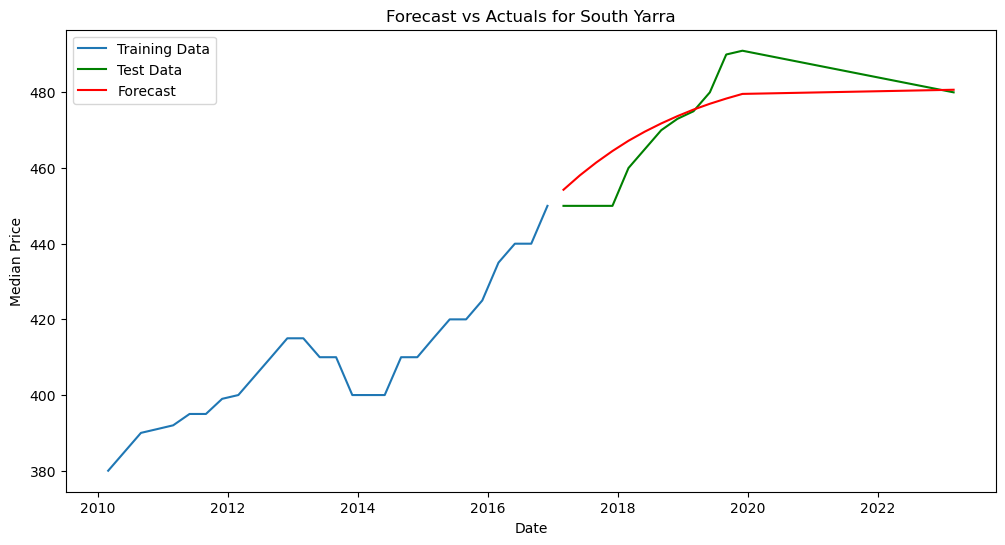

Processing Southbank


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

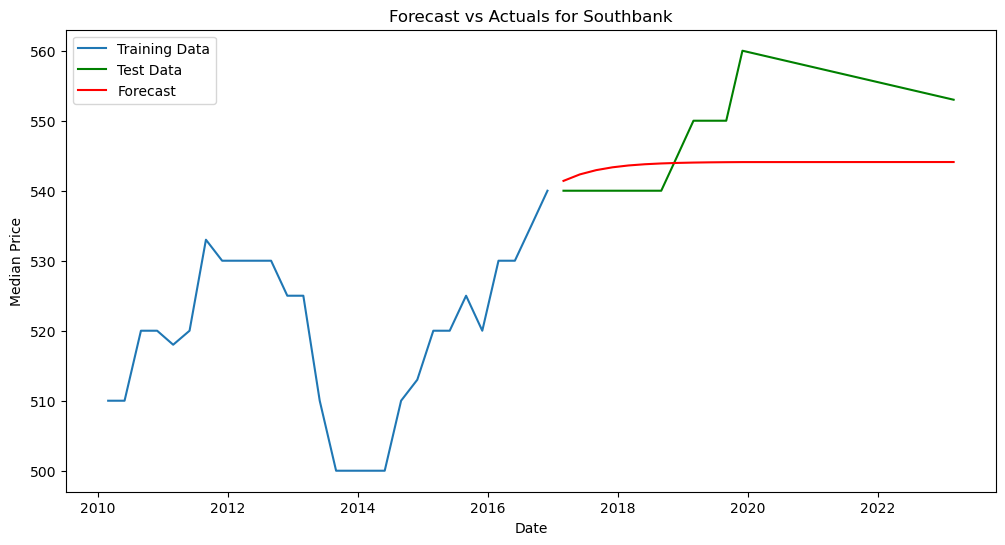

Processing St Kilda


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

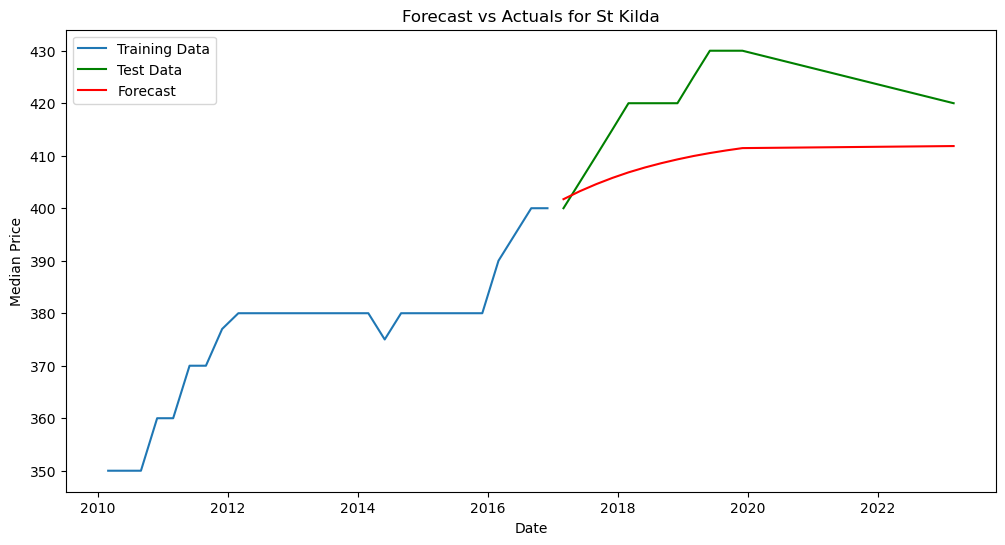

Processing Toorak


/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/xinyue/op

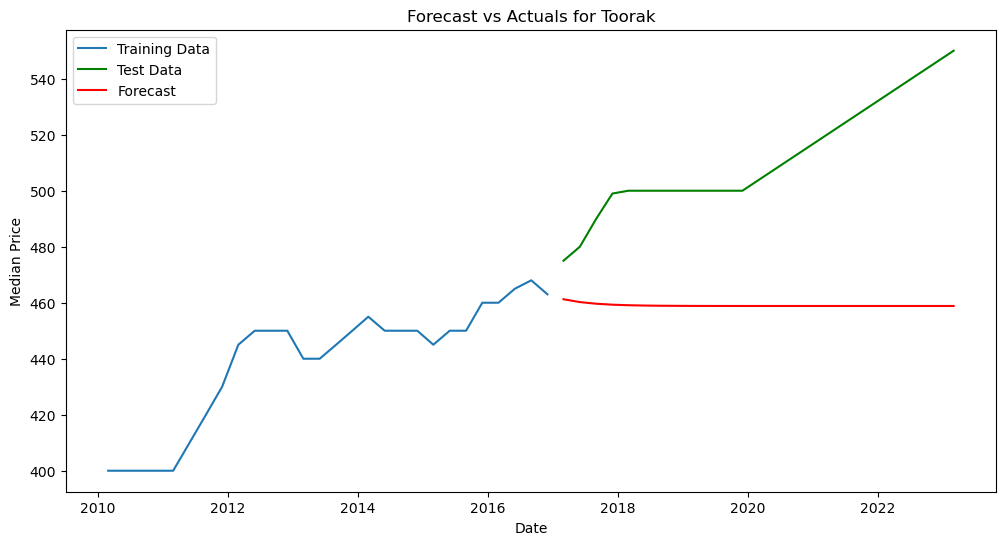

Top 10 Suburbs with the Highest Predicted Growth Rates:
South Yarra: 5.82%
Group Total: 4.83%
Elwood: 3.93%
Carlton North: 3.25%
Fitzroy North-Clifton Hill: 2.83%
St Kilda: 2.52%
Port Melbourne: 2.34%
Southbank: 0.50%
Fitzroy: 0.20%
Armadale: 0.10%


In [17]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import pandas as pd

# Group data by suburb
grouped = melted_data.groupby('Suburb')

# Dictionary to hold the last actual median price and the last forecasted price
growth_rates = {}

for suburb, group in grouped:
    print(f"Processing {suburb}")
    try:
        # Splitting the data based on date
        train = group[group['Date'] <= pd.Timestamp('2016-12-31')]
        test = group[group['Date'] > pd.Timestamp('2016-12-31')]

        # Ensure there are enough data points to model
        if len(train) > 20:
            model = ARIMA(train['Median Price'], order=(1,1,1)) 
            model_fit = model.fit()

            # Forecast
            forecast_steps = len(test)  # Dynamically determine how many steps to forecast based on available test data
            forecast = model_fit.forecast(steps=forecast_steps)

            # Plotting
            plt.figure(figsize=(12, 6))
            plt.plot(train['Date'], train['Median Price'], label='Training Data')
            plt.plot(test['Date'], test['Median Price'], label='Test Data', color='green')
            plt.plot(test['Date'], forecast, label='Forecast', color='red')
            plt.title(f"Forecast vs Actuals for {suburb}")
            plt.xlabel('Date')
            plt.ylabel('Median Price')
            plt.legend()
            plt.show()

            # Calculate predicted growth rate
            if len(forecast) > 0 and len(test) > 0:
                predicted_last = forecast.iloc[-1]
                last_actual = forecast.iloc[0]
                predicted_growth_rate = ((predicted_last - last_actual) / last_actual) * 100
                growth_rates[suburb] = predicted_growth_rate

        else:
            print(f"Not enough data points to train ARIMA model for {suburb}")

    except Exception as e:
        print(f"Failed to fit model for {suburb}: {e}")

# Now, let's print the top 10 suburbs with the highest predicted growth rates
top_10_suburbs = sorted(growth_rates, key=growth_rates.get, reverse=True)[:10]
print("Top 10 Suburbs with the Highest Predicted Growth Rates:")
for suburb in top_10_suburbs:
    print(f"{suburb}: {growth_rates[suburb]:.2f}%")

In [18]:
# Assuming 'data' is your DataFrame and 'Median Price' is the column you are forecasting
train = melted_data['Median Price'][:int(0.8 * len(data))]
test = melted_data['Median Price'][int(0.8 * len(data)):]
model = ARIMA(train, order=(1,1,1))  # Example: ARIMA model
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(test))

/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xinyue/opt/anaconda3/envs/mast30034_env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/xinyue/opt/a

In [19]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

def calculate_metrics(actual, predicted):
    """
    Calculate and return the evaluation metrics for the model.
    
    Parameters:
        actual (array-like): The actual observed values.
        predicted (array-like): The forecasted values from the model.
    
    Returns:
        dict: A dictionary containing MAE, MSE, RMSE, and MAPE.
    """
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100  # Handle cases where actual values are zero
    
    return {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    }

# Example usage:
# Assume 'test' is your actual data and 'forecast' is the data predicted by the model
metrics = calculate_metrics(test, forecast)

# Printing the metrics
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {metrics['MAE']}")
print(f"Root Mean Squared Error (RMSE): {metrics['RMSE']}")
print(f"Mean Absolute Percentage Error (MAPE): {metrics['MAPE']}%")

Evaluation Metrics:
Mean Absolute Error (MAE): 64.29860589365843
Root Mean Squared Error (RMSE): 80.45778948639668
Mean Absolute Percentage Error (MAPE): 12.933041427283856%
